# Xsuite Tutorial

This notebook provides a hands‑on introduction to the [Xsuite](https://xsuite.readthedocs.io) accelerator‑physics toolkit. Each section introduces a key concept and accompanies it with a short, runnable example.

> **Prerequisites**
> ```bash
> pip install xsuite notebook ipympl xplt
> ```

## Introduction

In the following tutorial we will review transverse beam dynamic concepts 


In [1]:
# import useful libraries
import numpy as np  # arrays and math
import matplotlib.pyplot as plt  # plots
import xtrack as xt  # tracking module of Xsuite
#%matplotlib widget

## Let's make one proton

In [2]:
part = xt.Particles(mass0=xt.PROTON_MASS_EV, p0c=1e9)  # Mass eV/c^2 Momentum in eV/c

In [3]:
print(f"Mass of the particle: {part.mass0 / 1e9} GeV/c^2")
print(f"Momentum of the particle: {part.p0c[0] / 1e9} GeV/c")
print(f"Energy of the proton: {part.energy0[0] / 1e9} GeV")
print(f"Relativistic beta: {part.beta0[0]}")
print(f"Relativistic gamma: {part.gamma0[0]}")

Mass of the particle: 0.93827208816 GeV/c^2
Momentum of the particle: 1.0 GeV/c
Energy of the proton: 1.3712601909995514 GeV
Relativistic beta: 0.7292562028443856
Relativistic gamma: 1.46147392457199


In [5]:
np.sqrt(part.mass0**2+part.p0c[0]**2)

1371260190.9995515

# Where is it going?

In [10]:
p1 = part.copy()  # copy the particle
drift = xt.Drift(length=10)
drift.track(p1)
print(f"Position after drift: s = {p1.s[0]} m")
print(f"Position after drift: x = {p1.x[0]} m")
print(f"Position after drift: y = {p1.y[0]} m")

Position after drift: s = 10.0 m
Position after drift: x = 0.0 m
Position after drift: y = 0.0 m


by convention:
- particles move in the positive s direction
- x is the horizontal position orthogonal to s
- y is the vertical position orthogonal to s

## Let's give some transverse momentum

In [11]:
p1 = part.copy()  # copy the particle
p1.px[0] = 0.1  # is a scaled horizontal momentum Px/P0 = gamma/gamma0 v_x/v_0
xt.Drift(length=10).track(p1)
print(f"Position after drift: s = {p1.s[0]} m")
print(f"Position after drift: x = {p1.x[0]} m")


Position after drift: s = 10.0 m
Position after drift: x = 1.0 m


Xsuite assumes small angle approximation! Let's make it exact

In [15]:
p1 = part.copy()
p1.px[0] = 0.1
line = xt.Line(elements=[xt.Drift(length=10)], element_names=["d1"]) # Beam line element
line.config.XTRACK_USE_EXACT_DRIFTS = True  # use exact drifts
line.reset_s_at_end_turn=False
line.track(p1)  # treat it as transfer line
print(f"Position after drift: s = {p1.s[0]} m")
print(f"Position after drift: x = {p1.x[0]} m")

Position after drift: s = 10.0 m
Position after drift: x = 1.005037815259212 m


## Let's work at problem. We want to transport a bunch particles for 10 m

In [16]:
env=xt.Environment()  # create a simulation environment
env.new('start',xt.Marker) # create a marker
env.new('stop',xt.Marker) # create a marker
line=env.new_line(
    name='line',
    components=[
       env.place('start',at=0),
       env.place('stop',at=10)]
)
line.get_table().cols['name s element_type']

Table: 4 rows, 3 cols
name                   s element_type
start                  0 Marker      
drift_1                0 Drift       
stop                  10 Marker      
_end_point            10             

In [17]:
np.linspace(-0.001,0.001,11)

array([-0.001 , -0.0008, -0.0006, -0.0004, -0.0002,  0.    ,  0.0002,
        0.0004,  0.0006,  0.0008,  0.001 ])

Let's track particles

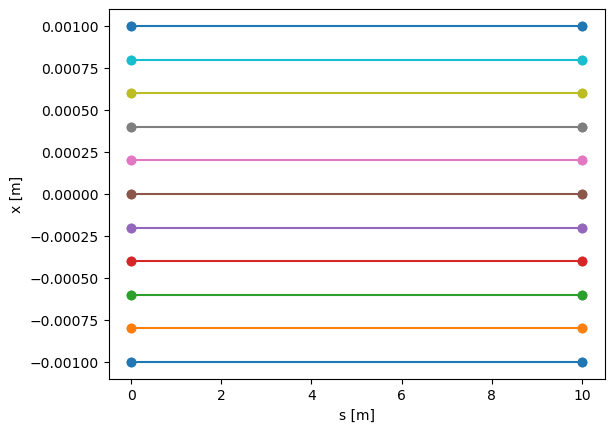

In [20]:
part=xt.Particles(mass0=xt.PROTON_MASS_EV, p0c=1e9,x=np.linspace(-0.001,0.001,11))
p1=part.copy()  # copy the particles
line.track(p1, turn_by_turn_monitor="ONE_TURN_EBE")  # collect element by element data
data=line.record_last_track # extract data
fig,ax=plt.subplots() # make figure 
ax.plot(data.s.T, data.x.T, 'o-') # Transpose data
ax.set_xlabel('s [m]');
ax.set_ylabel('x [m]');

Unfortunaly particles have always a momentum spread

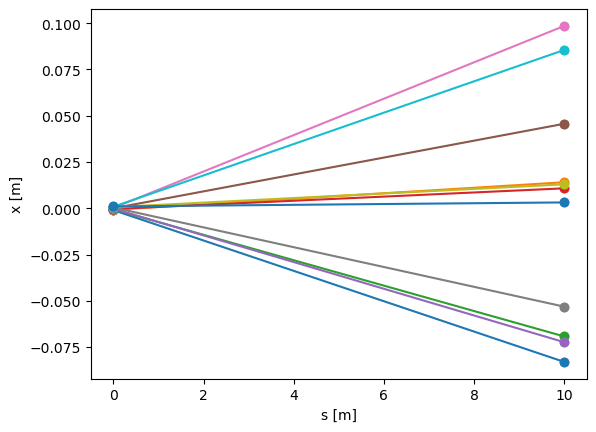

In [21]:
p1=part.copy()  # copy the particles
p1.px=np.random.uniform(-0.01,0.01,11)  # random the horizontal momentum

def track_and_plot(line, part):
    line.track(part.copy(), turn_by_turn_monitor="ONE_TURN_EBE")  # collect element by element data
    data=line.record_last_track
    fig,ax=plt.subplots()
    ax.plot(data.s.T, data.x.T, 'o-')
    ax.set_xlabel('s [m]')
    ax.set_ylabel('x [m]')
    plt.show()

track_and_plot(line, p1)  # track the particles

# Let's improve the line

In [37]:
env['kf']=0.3
if 'qf' not in env.elements:
   env.new("qf",xt.Quadrupole, length=0.20, k1='kf') # k1 is scaled gradient k1=e/p G [1/m]
line2=line.copy(shallow=True)
line2.insert("qf",at=5)  # add a quadrupole to the line

def track_and_plot(line, part):
    line.track(part.copy(), turn_by_turn_monitor="ONE_TURN_EBE")  # collect element by element data
    data=line.record_last_track
    fig,ax=plt.subplots(1)
    ax.plot(data.s.T, data.x.T, 'o-')
    ax.set_ylabel('x [m]')
    ax.fill_between([9.5,10.2],[-0.03,-0.03],[0.03,0.03],color='b',alpha=0.5) # add a reference at the end of the line
    ax.set_ylim(-0.2,0.2)
    plt.show()

line2.get_table().cols['name s element_type']

Slicing line:   0%|          | 0/3 [00:00<?, ?it/s]

Table: 6 rows, 3 cols
name                    s element_type
start                   0 Marker      
drift_1..27             0 DriftSlice  
qf                    4.9 Quadrupole  
drift_1..29           5.1 DriftSlice  
stop                   10 Marker      
_end_point             10             

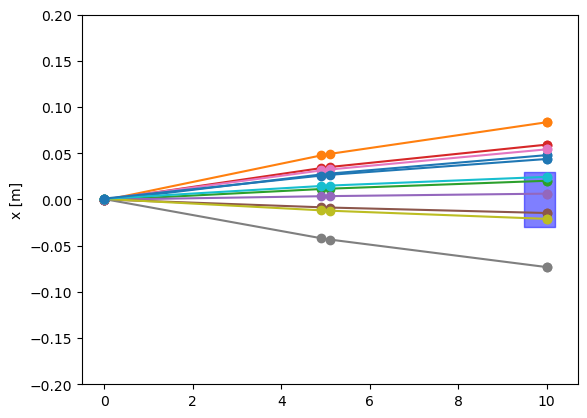

In [38]:
data=track_and_plot(line2, p1)  # track the particles

0.6


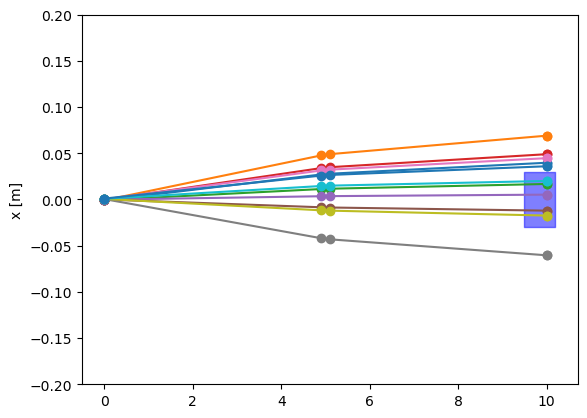

In [39]:
env['kf']+=0.3
print(line2['qf'].k1)
data=track_and_plot(line2, p1)  # track the particles

1.8


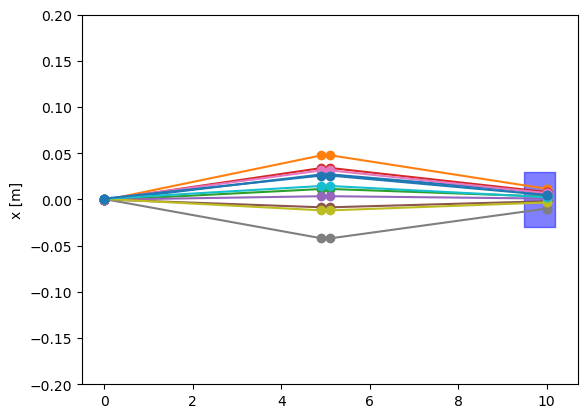

In [40]:
env['kf']=1.8
print(line2['qf'].k1)
data=track_and_plot(line2, p1) 

How to find the gradient in [Tesla/m]?

In [30]:
# k1 = e/P*G -> G = P/e * k1 -> 1eV/c / e * k1
print(f"{part.p0c[0]/2.998e8*env['kf']} [T/m] ")

6.00400266844563 [T/m] 


## 2 planes....

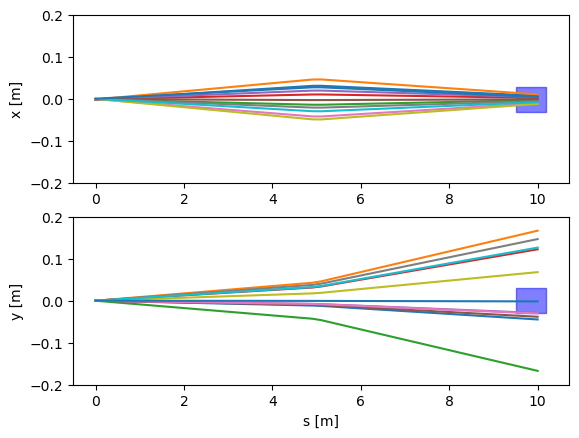

In [41]:
p1=part.copy()  # copy the particles
p1.px=np.random.uniform(-0.01,0.01,11)  # random the horizontal momentum
p1.py=np.random.uniform(-0.01,0.01,11)  # random the vertical momentum

def track_and_plot(line, part):
    line.track(part.copy(), turn_by_turn_monitor="ONE_TURN_EBE")  # collect element by element data
    data=line.record_last_track
    fig,(ax1,ax2)=plt.subplots(2)
    ax1.plot(data.s.T, data.x.T, '-')
    ax2.plot(data.s.T, data.y.T, '-')
    ax2.set_xlabel('s [m]')
    ax1.set_ylabel('x [m]')
    ax2.set_ylabel('y [m]')
    ax1.fill_between([9.5,10.2],[-0.03,-0.03],[0.03,0.03],color='b',alpha=0.5)
    ax2.fill_between([9.5,10.2],[-0.03,-0.03],[0.03,0.03],color='b',alpha=0.5)
    [ax.set_ylim(-0.2,0.2) for ax in [ax1,ax2]]
    plt.show()

data=track_and_plot(line2, p1)  # track the particles

## let's improve

In [43]:
env['kd']=-0.3
if 'qd' not in env.elements:
   env.new("qd",xt.Quadrupole, length=0.20, k1='kd') # k1 is scaled gradient k1=e/q G [1/m]
line3=line.copy(shallow=True)
line3.insert("qf",at=3)
line3.insert("qd",at=6)
line3.get_table()
#line3.survey().plot()

Slicing line:   0%|          | 0/3 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/5 [00:00<?, ?it/s]

Table: 8 rows, 11 cols
name                       s element_type isthick isreplica parent_name iscollective       s_start ...
start                      0 Marker         False     False None               False             0
drift_1..33                0 DriftSlice      True     False drift_1            False             0
qf                       2.9 Quadrupole      True     False None               False           2.9
drift_1..35..0           3.1 DriftSlice      True     False drift_1            False           3.1
qd                       5.9 Quadrupole      True     False None               False           5.9
drift_1..35..2           6.1 DriftSlice      True     False drift_1            False           6.1
stop                      10 Marker         False     False None               False            10
_end_point                10                False     False None               False            10

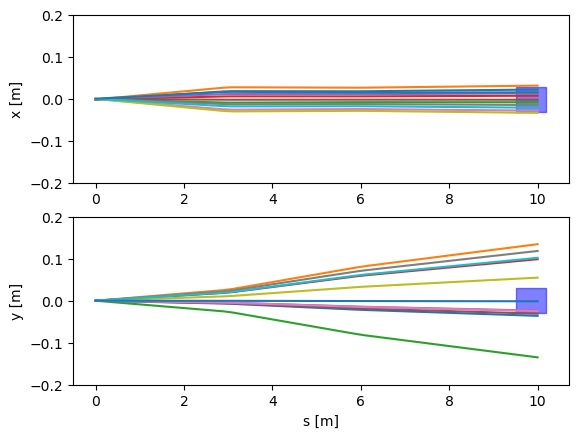

1.8 -0.3


In [44]:
track_and_plot(line3, p1);
print(env['kf'],env['kd'])

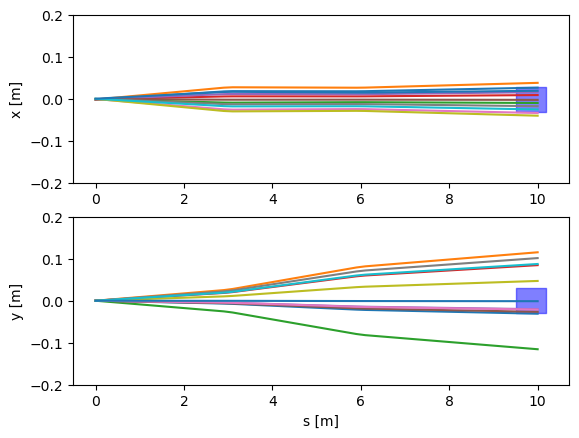

In [45]:
env['kd']+=-0.3
track_and_plot(line3, p1)

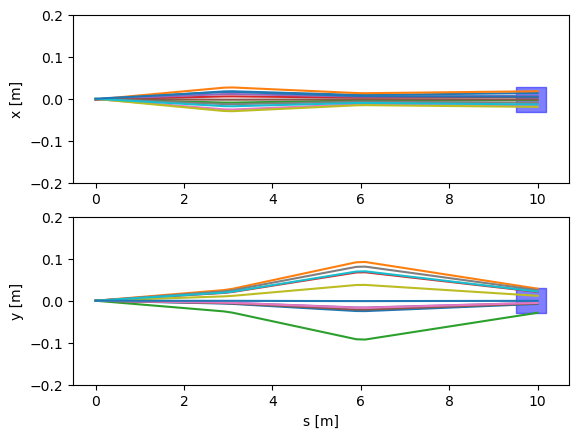

In [46]:
env['kf']=2.6
env['kd']=-2.1
track_and_plot(line3, p1); # track the particles

## Now the problem has changed and we need to transport the particles for 100 meters.

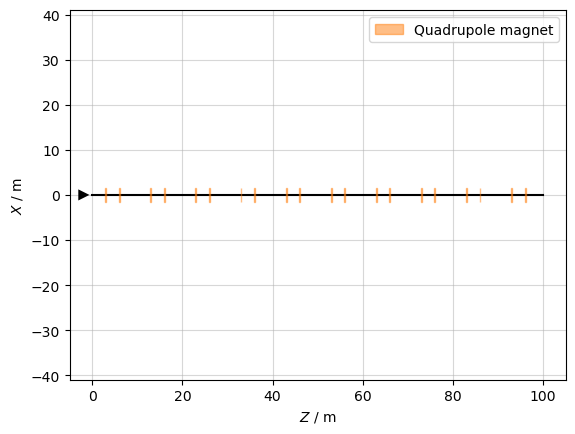

In [47]:
line4=(10*line3)
line4.survey().plot()

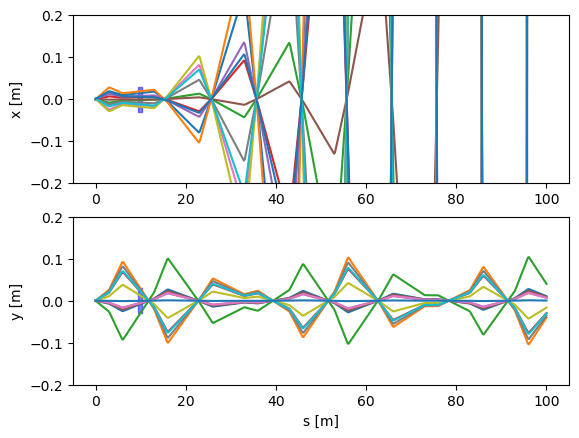

In [48]:
track_and_plot(line4, p1); # track the particles

## Let's use some theory

In [50]:
line3.particle_ref=xt.Particles(mass0=xt.PROTON_MASS_EV, p0c=1e9)
m=line3.twiss4d(betx=1,bety=1).get_R_matrix(start="start",end="stop") # transfer matrix
print(m[:4,:4])   #  z = [x,px,y,py]  zf=f(zi)     R_ij = d zf[i] d zi[j]    

[[-3.4851722   1.65119795  0.          0.        ]
 [-0.73812288  0.06277652  0.          0.        ]
 [ 0.          0.          0.41722352  3.2815055 ]
 [ 0.          0.         -0.54237356 -1.86902653]]


[-3.09979355+0.j         -0.32260213+0.j         -0.7259015 +0.68779867j
 -0.7259015 -0.68779867j]


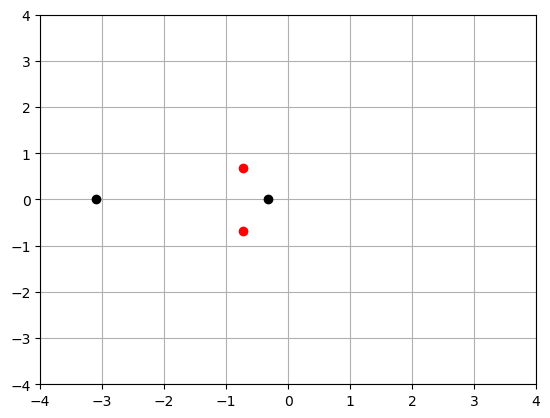

In [52]:
eig=np.linalg.eigvals(m[:4,:4])
print(eig)
plt.plot(eig[:2].real,eig[:2].imag,'ok')
plt.plot(eig[2:].real,eig[2:].imag,'or')
plt.grid()
plt.xlim(-4,4);plt.ylim(-4,4);

[-0.36932741+0.92929934j -0.36932741-0.92929934j  0.02756973+0.99961988j
  0.02756973-0.99961988j]


(-4.0, 4.0)

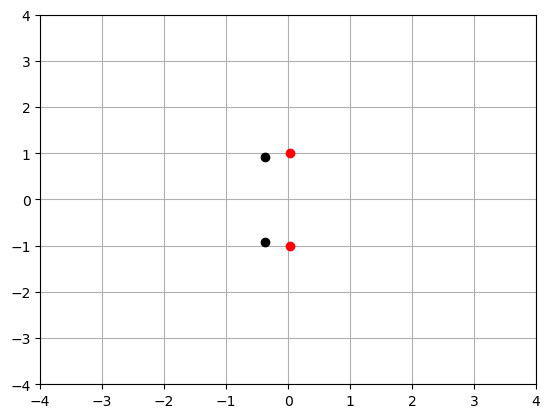

In [53]:
env['kf']=1.8;env['kd']=-1.6
m=line3.twiss4d(betx=1,bety=1).get_R_matrix(start="start",end="stop")
eig=np.linalg.eigvals(m[:4,:4])
print(eig)
plt.plot(eig[:2].real,eig[:2].imag,'ok')
plt.plot(eig[2:].real,eig[2:].imag,'or')
plt.grid()
plt.xlim(-4,4);plt.ylim(-4,4)

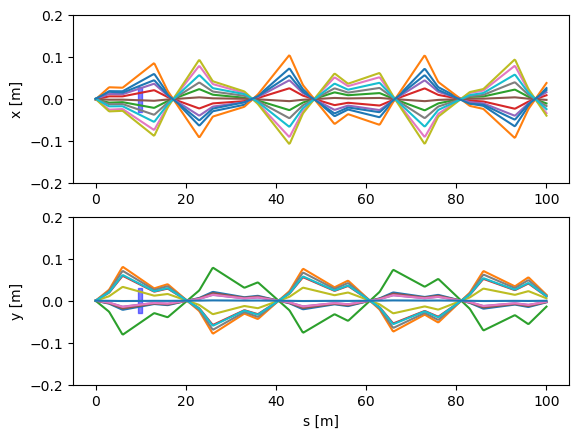

In [54]:
track_and_plot(10*line3,p1)

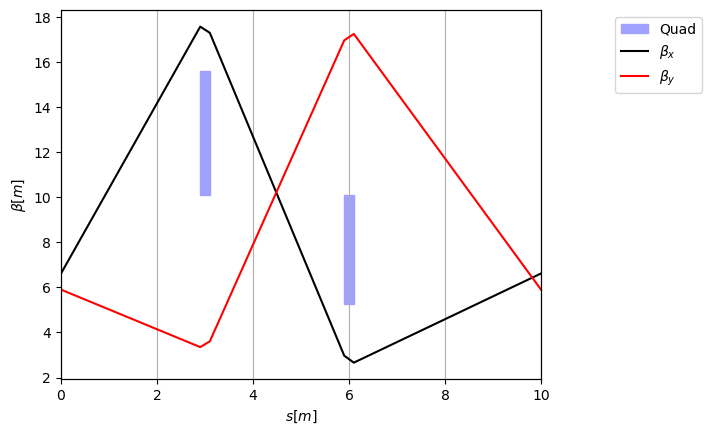

In [55]:
tw=line3.twiss4d()
tw.plot('betx bety')

In [56]:
tw.rows['start'].cols['betx alfx bety alfy']

TwissTable: 1 row, 5 cols
name           betx          alfx          bety          alfy
start       6.61757      -1.29903       5.90147      0.872393

Text(0, 0.5, 'px')

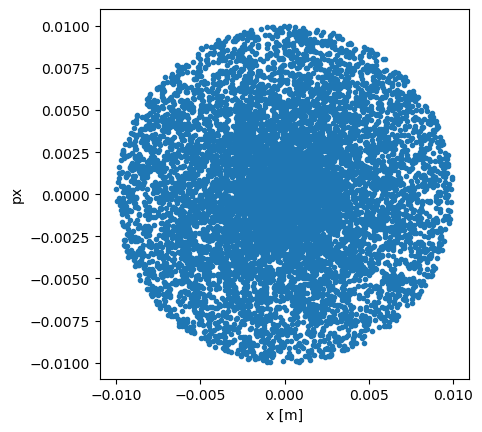

In [57]:
a=np.random.rand(10000)*0.01
phi=np.random.rand(10000)*2*np.pi
p0=line3.build_particles(x=a*np.cos(phi),px=a*np.sin(phi))
fig,ax=plt.subplots()
ax.set_aspect('equal')
ax.plot(p0.x,p0.px,'.')
ax.set_xlabel("x [m]")
ax.set_ylabel("px")

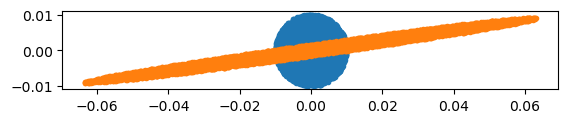

In [58]:
p1=p0.copy()
line3.track(p1)
fig,ax=plt.subplots()
ax.set_aspect('equal')
ax.plot(p0.x,p0.px,'.')
ax.plot(p1.x,p1.px,'.')

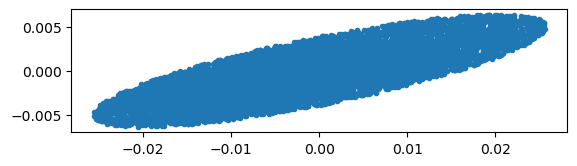

In [59]:
a=np.random.rand(10000)*0.01
phi=np.random.rand(10000)*2*np.pi
p0=line3.build_particles(x_norm=a*np.cos(phi),px_norm=a*np.sin(phi),method='4d')
fig,ax=plt.subplots()
ax.set_aspect('equal')
ax.plot(p0.x,p0.px,'.')

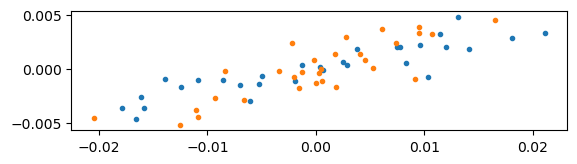

In [62]:
p1=p0.copy()
line3.track(p1)
fig,ax=plt.subplots()
ax.set_aspect('equal')
ax.plot(p0.x,p0.px,'.')
ax.plot(p1.x,p1.px,'.')

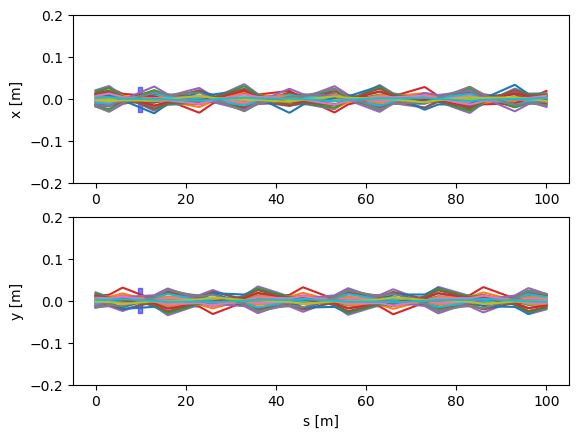

In [64]:
p0=line3.build_particles(
    x_norm=(a*np.cos(phi))[:30],px_norm=(a*np.sin(phi))[:30],
    y_norm=(a*np.cos(phi))[:30],py_norm=(a*np.sin(phi))[:30]
    ,method='4d')
track_and_plot(line4,p0)